# Necessary Upgrades
Run the cells in this section to make sure you have the latest version of sklearn and joblib.

Restart your kernel after installing.

In [1]:
## Update sklearn to prevent version mismatches
# !pip install sklearn --upgrade

In [2]:
## install joblib. This will be used to save your model. 
# !pip install joblib
## Restart your kernel after installing 

# Import Dependencies

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import joblib

# Read the CSV and Perform Basic Data Cleaning

In [2]:
df = pd.read_csv("data/exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
# df.head()

In [3]:
# drop the error columns
df = df.loc[:, ~df.columns.str.contains('_err')]
df.columns

# column definitions is available at the end of this notebook.

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg',
       'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

# Select your features (columns) and y-variable.
Column definitions are available at the end of this notebook.

Use `koi_disposition` for the y values

In [4]:
y = df[['koi_disposition']]

In [5]:
# test with a subset
# selected_features = df[['koi_fpflag_nt', 'koi_prad', 'koi_teq', 'koi_srad']]

# all the columns minus y
selected_features = df.drop(columns=["koi_disposition"])
feature_names = selected_features.columns
# selected_features.head()

# Create a Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, random_state=42, stratify = y)
# X_train.head()

# Pre-processing

Scale the data and perform some feature selection

In [7]:
# Scale your data
scaler = QuantileTransformer(output_distribution='normal')
normalizer = Normalizer()

X_train_s = scaler.fit_transform(X_train)
X_train_sn= normalizer.fit_transform(X_train_s)

X_test_s = scaler.fit_transform(X_test)
X_test_sn = normalizer.fit_transform(X_test_s)

# Train the Model



k: 1, Train/Test Score: 1.000/0.846
k: 3, Train/Test Score: 0.922/0.864
k: 5, Train/Test Score: 0.906/0.864
k: 7, Train/Test Score: 0.899/0.870
k: 9, Train/Test Score: 0.894/0.875
k: 11, Train/Test Score: 0.889/0.877
k: 13, Train/Test Score: 0.888/0.880
k: 15, Train/Test Score: 0.890/0.879
k: 17, Train/Test Score: 0.887/0.887
k: 19, Train/Test Score: 0.885/0.888
k: 21, Train/Test Score: 0.883/0.887
k: 23, Train/Test Score: 0.880/0.883
k: 25, Train/Test Score: 0.882/0.882
k: 27, Train/Test Score: 0.881/0.883
k: 29, Train/Test Score: 0.879/0.885
highest max score for consideration: 0.8878718535469108; number of neighbors: 19


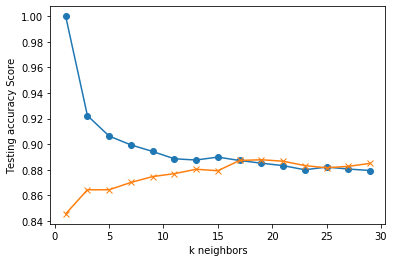

In [9]:
train_scores = []
test_scores = []

for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sn, y_train)
    train_score = knn.score(X_train_sn, y_train)
    test_score = knn.score(X_test_sn, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")    

print (f"highest max score for consideration: {np.amax(test_scores)}; number of neighbors: {(np.argmax(test_scores)*2)+1}")

plt.plot(range(1, 30, 2), train_scores, marker='o')
plt.plot(range(1, 30, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [10]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train_sn, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [11]:
print(f"Minmax Training Data Score: {knn.score(X_train_sn, y_train)}")
print(f"Minmax Testing Data Score: {knn.score(X_test_sn, y_test)}")

predictions = knn.predict(X_test_sn)
print(classification_report(y_test, predictions))

Minmax Training Data Score: 0.8851802403204272
Minmax Testing Data Score: 0.8878718535469108
                precision    recall  f1-score   support

     CANDIDATE       0.87      0.65      0.75       422
     CONFIRMED       0.74      0.89      0.81       450
FALSE POSITIVE       0.99      1.00      0.99       876

      accuracy                           0.89      1748
     macro avg       0.87      0.85      0.85      1748
  weighted avg       0.89      0.89      0.89      1748



# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [12]:
# Create the GridSearchCV model
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn_search = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_search, param_grid, cv = 10, scoring = 'accuracy', verbose = 2)

In [13]:
# Train the model with GridSearch
best_knn_model = knn_grid.fit(X_train_sn, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.1s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.1s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=7, weights=uniform, total=   0.1s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.1s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.1s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.1s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.1s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.1s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.1s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.1s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.1s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.1s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.1s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.1s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.1s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.1s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=13, weights=uniform, total=   0.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=16, weights=uniform, total=   0.1s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.1s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.1s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.1s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.1s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.1s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.1s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=19, weights=uniform, total=   0.1s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.1s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.1s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.1s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.1s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.1s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.1s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.1s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.1s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.1s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.1s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.1s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.1s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.1s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.1s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.1s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.1s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.1s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.1s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.1s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.1s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.1s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.1s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.1s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.1s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.1s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.1s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.1s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   37.0s finished


In [14]:
print(f"Minmax best params: {best_knn_model.best_params_}")
print(f"Minmax best score: {best_knn_model.best_score_}")
print(f"Minmax best best estimator: {best_knn_model.best_estimator_}")

Minmax best params: {'n_neighbors': 18, 'weights': 'uniform'}
Minmax best score: 0.8744980007270085
Minmax best best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                     weights='uniform')


# Test Model

In [15]:
print(f"Minmax Training Data Score: {best_knn_model.score(X_train_sn, y_train)}")
print(f"Minmax Testing Data Score: {best_knn_model.score(X_test_sn, y_test)}")

predictions_best = best_knn_model.predict(X_test_sn)
print(classification_report(y_test, predictions_best))

Minmax Training Data Score: 0.888613389280946
Minmax Testing Data Score: 0.8924485125858124
                precision    recall  f1-score   support

     CANDIDATE       0.86      0.69      0.77       422
     CONFIRMED       0.75      0.88      0.81       450
FALSE POSITIVE       0.99      1.00      0.99       876

      accuracy                           0.89      1748
     macro avg       0.87      0.85      0.86      1748
  weighted avg       0.90      0.89      0.89      1748



In [16]:
# see how it compares
predicted = predictions_best[:20]
actual = y_test["koi_disposition"][:20].tolist()
pd.DataFrame({"Actual": actual, "Predicted": predicted}).reset_index(drop=True)

,Actual,Predicted
0,CANDIDATE,CANDIDATE
1,FALSE POSITIVE,FALSE POSITIVE
2,FALSE POSITIVE,FALSE POSITIVE
3,FALSE POSITIVE,FALSE POSITIVE
4,CANDIDATE,CANDIDATE
5,FALSE POSITIVE,FALSE POSITIVE
6,CANDIDATE,CANDIDATE
7,FALSE POSITIVE,FALSE POSITIVE
8,FALSE POSITIVE,FALSE POSITIVE
9,FALSE POSITIVE,FALSE POSITIVE


# Save the Model

In [17]:
knn_save = 'models/knn.h5'
joblib.dump(best_knn_model, knn_save)

['models/knn.h5']

In [18]:
loaded_model = joblib.load("models/knn.h5")
print(f"{loaded_model.score(X_test_sn, y_test)}")

0.8924485125858124


# Column Details

### Exoplanet Archive Information
* 'koi_disposition': The pipeline flag that designates the most probable physical explanation of the KOI

### Project Disposition Columns
* 'koi_fpflag_nt': A KOI whose light curve is not consistent with that of a transiting planet.
* 'koi_fpflag_ss': A KOI that is observed to have a significant secondary event, transit shape, or out-of-eclipse variability, which indicates that the transit-like event is most likely caused by an eclipsing binary.
* 'koi_fpflag_co': The source of the signal is from a nearby star, as inferred by measuring the centroid location of the image both in and out of transit, or by the strength of the transit signal in the target's outer (halo) pixels as compared to the transit signal from the pixels in the optimal (or core) aperture.
* 'koi_fpflag_ec': The KOI shares the same period and epoch as another object and is judged to be the result of flux contamination in the aperture or electronic crosstalk.

### Transit Properties
Transit parameters delivered by the Kepler Project are typically best-fit parameters produced by a Mandel-Agol (2002) fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris. Some of the parameters listed below are fit directly, other are derived from the best-fit parameters. Limb-darkening coefficients are fixed and pre-calculated from host star properties. Orbital Period, Transit Epoch, Planet-Star Radius Ratio, Planet-Star Distance over Star Radius and Impact Parameter are the free parameters in the fit. Matrix covariances are adopted as errors to the fit parameters; they therefore ignore the effects of correlation between the fit parameters and are likely to be underestimates.

See the links in the Purpose of KOI document for each activity table for more details on the fits for each delivery.

Scaled planetary parameters combine the dimensionless fit parameters with physical stellar parameters to produce planet characteristics in physical units.

Best-fit planetary transit parameters are typically normalized to the size of the host star. Physical planet parameters may be derived by scaling to the star's size and temperature. Transit parameters also depend weakly upon the limb-darkening coefficients which are derived from the stellar parameters (e.g., Claret and Bloemen 2011).

* 'koi_period': The interval between consecutive planetary transits.
* 'koi_time0bk': The time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days. The offset corresponds to 12:00 on Jan 1, 2009 UTC.
* 'koi_impact': The sky-projected distance between the center of the stellar disc and the center of the planet disc at conjunction, normalized by the stellar radius
* 'koi_duration': The duration of the observed transits. Duration is measured from first contact between the planet and star until last contact. Contact times are typically computed from a best-fit model produced by a Mandel-Agol (2002) model fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris.
* 'koi_depth': The fraction of stellar flux lost at the minimum of the planetary transit. Transit depths are typically computed from a best-fit model produced by a Mandel-Agol (2002) model fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris.
* 'koi_prad': The radius of the planet. Planetary radius is the product of the planet star radius ratio and the stellar radius.
* 'koi_teq': Approximation for the temperature of the planet. 
* 'koi_insol': Insolation flux is another way to give the equilibrium temperature.

### Threshold-Crossing Event (TCE) Information
The Transiting Planet Search (TPS) module of the Kepler data analysis pipeline performs a detection test for planet transits in the multi-quarter, gap-filled flux time series. The TPS module detrends each quarterly PDC light curve to remove edge effects around data gaps and then combines the data segments together, filling gaps with interpolated data so as to condition the flux time series for a matched filter. The module applies an adaptive, wavelet-based matched filter (Jenkins 2002, Jenkins et al. 2010 and Tenenbaum et al. (2012)) to perform a joint characterization of observation noise and detection of transit-like features in the light curve.

The TPS module estimates the Power Spectral Density of the flux time series as a function in time. This provides coefficients for a whitening filter to accommodate non-stationary, non-white noise and yields Single Event Statistic (SES) time series components. These can be interpreted as measurements of the statistical significance of the presence of a transit of trial duration at each point in the time series.

Single Event Statistics are folded at each trial orbital period and the maximum Multiple Event Statistic (MES) is obtained over all trial periods and phases. The MES estimates the signal to noise ratio of the putative transit-like sequence against the measurement noise. The MES threshold for defining the sample of Threshold Crossing Events (TCEs) is provided within the Release Notes. For reference, a lower MES threshold of 7.1σ limits the number of false positives in the TCE sample due to statistical random noise to less than 1 over the primary mission (Jenkins, Caldwell and Borucki 2002).

* 'koi_model_snr': Transit depth normalized by the mean uncertainty in the flux during the transits.
* 'koi_tce_plnt_num': TCE Planet Number federated to the KOI.

### Stellar Parameters
Stellar effective temperature, surface gravity, metallicity, radius, mass, and age should comprise a consistent set. Associated error estimates are 1-σ uncertainties.

* 'koi_steff': The photospheric temperature of the star.
* 'koi_slogg': The base-10 logarithm of the acceleration due to gravity at the surface of the star.
* 'koi_srad': The photospheric radius of the star

### KIC Parameters
* 'ra': KIC Right Ascension
* 'dec': KIC Declination
* 'koi_kepmag': Kepler-band (mag)